In [1]:
# install package
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy

%matplotlib notebook

## カメラ1

In [2]:
path = "original1.png"
origin_img = cv2.imread(path)

In [3]:
# define court size
width = 1800
height = 900

margin = 600
w_margin = 600
h_margin = 1200

In [4]:
cp_origin = []

In [5]:
def click(event, x, y, flags, params):
    global cp_origin
    if event == cv2.EVENT_LBUTTONDOWN:
        cp_origin.append([x,y])
        print(x, y)
    elif event == cv2.EVENT_RBUTTONDOWN:
        cp_origin = []
        print("clear")

In [6]:
# Click on corners of the court in the order of TL, BL, BR, TR.
#  can be 
cv2.imshow("window1", origin_img)
cv2.setMouseCallback("window1", click)
cv2.waitKey(0)
cv2.destroyAllWindows

639 138
27 148
118 1035
1221 913


<function destroyAllWindows>

In [7]:
# B, R, =>
cp_origin = np.float32(cp_origin)
cp_trans = np.float32([[0,0], [0, height], [width, height], [width, 0]])+margin
print(cp_origin)
print(cp_trans)

[[ 639.  138.]
 [  27.  148.]
 [ 118. 1035.]
 [1221.  913.]]
[[ 600.  600.]
 [ 600. 1500.]
 [2400. 1500.]
 [2400.  600.]]


In [8]:
M = cv2.getPerspectiveTransform(cp_origin, cp_trans)
trans_img = cv2.warpPerspective(origin_img, M, (width+w_margin, height+h_margin))
print(M)

[[ 1.31565078e-02  5.36552252e+00 -8.53517797e+01]
 [-1.77920876e+00  2.03788485e+00  1.51918363e+03]
 [-1.03807573e-04  1.24755024e-03  1.00000000e+00]]


<IPython.core.display.Javascript object>


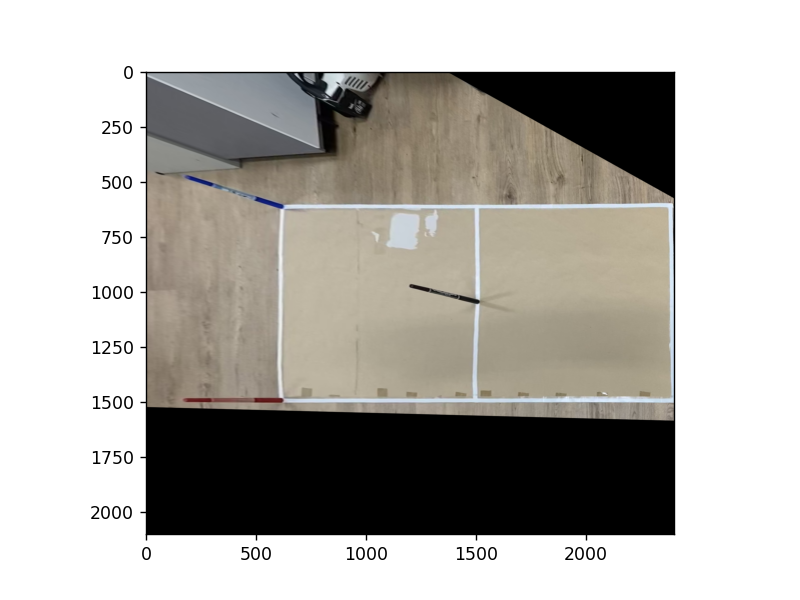

In [9]:
# cv2 : BGR
# matplotlib : RGB
plot_img = cv2.cvtColor(trans_img, cv2.COLOR_BGR2RGB)
plt.imshow(plot_img)

In [10]:
pb = [0, 0, 0]
pr = [0, 0, 0]
click = True

In [11]:
def click_pen(event, x, y, flags, params):
    global pb, pr, click
    if event == cv2.EVENT_LBUTTONDOWN:
        if click:
            pb = [x-margin, y-margin, 0]
        else:
            pr = [x-margin, y-margin, 0]
        click = not click
        print(x, y)

In [13]:
cv2.imshow("window2", trans_img)
cv2.setMouseCallback("window2", click_pen)
cv2.waitKey(0)
cv2.destroyAllWindows()

182 472
177 1491


In [14]:
real_b = [0, 0, 140]
real_r = [0, 900, 140]

blue_direction = [real - image for (real, image) in zip(real_b, pb)]
red_direction = [real - image for (real, image) in zip(real_r, pr)]

In [15]:
blue_direction

[418, 128, 140]

In [16]:
red_direction

[423, 9, 140]

In [19]:
points = 13

x_b = [pb[0]+i*blue_direction[0] for i in range(points)]
y_b = [pb[1]+i*blue_direction[1] for i in range(points)]
z_b = [pb[2]+i*blue_direction[2] for i in range(points)]

x_r = [pr[0]+i*red_direction[0] for i in range(points)]
y_r = [pr[1]+i*red_direction[1] for i in range(points)]
z_r = [pr[2]+i*red_direction[2] for i in range(points)]

<IPython.core.display.Javascript object>


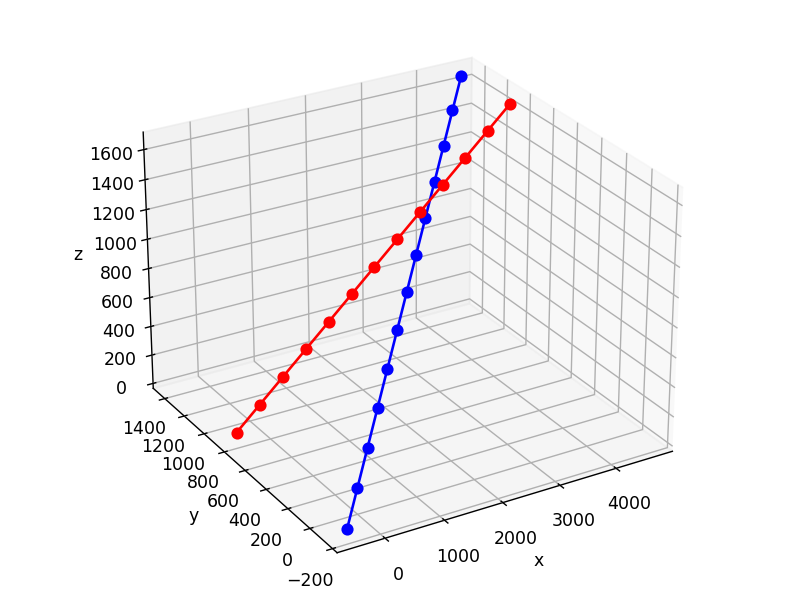

In [20]:
#3D Plot
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot(x_b, y_b, z_b, "o-", color="Blue")
ax.plot(x_r, y_r, z_r, "o-", color="Red")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### 3次元空間上のねじれた2直線の最近接点を求める
直線1：

    1点：pb
    
    ベクトル:blue_direction
    
    媒介変数：t
直線2：

    1点：pr

    ベクトル：red_direction
    
    媒介変数：s

In [32]:
#記号s, tを扱う
t = sympy.Symbol("t")
s = sympy.Symbol("s")

In [33]:
# 2乗距離
R = ((pb[0]+t*blue_direction[0]) - (pr[0]+s*red_direction[0]))**2+((pb[1]+t*blue_direction[1]) - (pr[1]+s*red_direction[1]))**2+((pb[2]+t*blue_direction[2]) - (pr[2]+s*red_direction[2]))**2

In [34]:
# 偏微分
dR_dt = sympy.diff(R, t)
dR_ds = sympy.diff(R, s)
print("dR/dt = ", dR_dt)
print("dR/ds = ", dR_ds)

dR/dt =  -425870*s + 467466*t - 288196
dR/ds =  416154*s - 425870*t + 29516


In [35]:
# 解く
ans = sympy.solve([dR_dt, dR_ds])
ans

{s: 1702129751/205821701, t: 1677561551/205821701}

In [36]:
t_val = ans[t]
s_val = ans[s]

In [37]:
b = [pb[0]+t_val*blue_direction[0], pb[1]+t_val*blue_direction[1], pb[2]+t_val*blue_direction[2]]
r = [pr[0]+s_val*red_direction[0], pr[1]+s_val*red_direction[1], pr[2]+s_val*red_direction[2]]

In [38]:
b

[650509013700/205821701, 201628359450/205821701, 234858617140/205821701]

In [39]:
r

[649397693700/205821701, 201698919450/205821701, 238298165140/205821701]

<IPython.core.display.Javascript object>


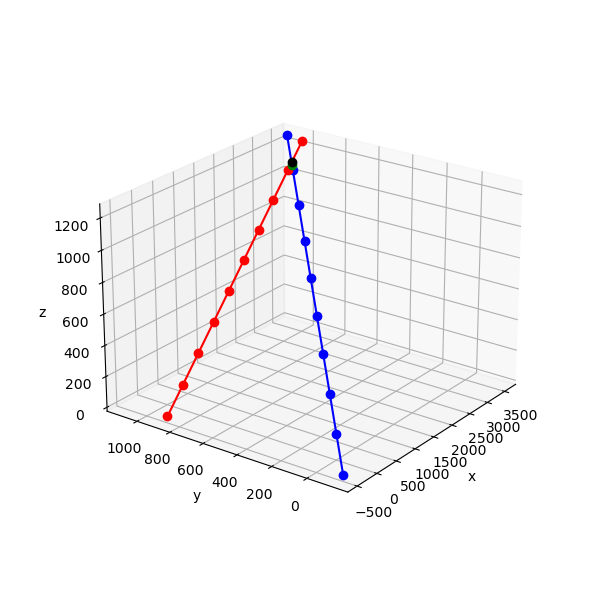

In [40]:
#3D Plot
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection="3d")
ax.plot(x_b, y_b, z_b, "o-", color="Blue")
ax.plot(x_r, y_r, z_r, "o-", color="Red")
ax.plot(b[0], b[1], b[2], "o-", color="Green")
ax.plot(r[0], r[1], r[2], "o-", color="Black")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [41]:
camera = [(b[0]+r[0])/2, (b[1]+r[1])/2, (b[2]+r[2])/2]
camera

[649953353700/205821701, 201663639450/205821701, 236578391140/205821701]

In [42]:
black_coord = [0, 0, 0]

In [43]:
def print_coord(event, x, y, flags, params):
    global black_coord
    if event == cv2.EVENT_LBUTTONDOWN:
        black_coord = [x-margin, y-margin, 0]
        print(black_coord)

In [44]:
#黒ペンクリック
cv2.imshow("window2", trans_img)
cv2.setMouseCallback("window2", print_coord)
cv2.waitKey(0)
cv2.destroyAllWindows()

[604, 371, 0]


In [45]:
#方向ベクトル
black_direction = [camera[0]-black_coord[0], camera[1]-black_coord[1],camera[2]-black_coord[2]]

<IPython.core.display.Javascript object>


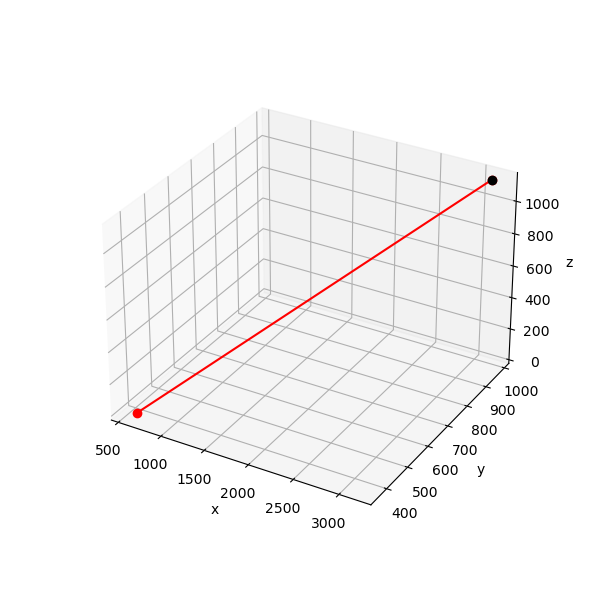

In [47]:
#3D Plot
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection="3d")
ax.plot([black_coord[0], camera[0]],[black_coord[1], camera[1]],[black_coord[2], camera[2]], "o-", color = "Red")
ax.plot(camera[0], camera[1], camera[2], "o-", color="Black")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [48]:
black_coord

[604, 371, 0]

## カメラ1
camera1 = [649953353700/205821701, 201663639450/205821701, 236578391140/205821701]

black_coord = [604, 371, 0]

## カメラ2

In [3]:
path = "original2.png"
origin_img = cv2.imread(path)

In [4]:
# define court size
width = 1800
height = 900

margin = 600
w_margin = 600
h_margin = 1200

In [5]:
cp_origin = []

In [6]:
def click(event, x, y, flags, params):
    global cp_origin
    if event == cv2.EVENT_LBUTTONDOWN:
        cp_origin.append([x,y])
        print(x, y)
    elif event == cv2.EVENT_RBUTTONDOWN:
        cp_origin = []
        print("clear")

In [7]:
# Click on corners of the court in the order of TL, BL, BR, TR.
#  can be 
cv2.imshow("window3", origin_img)
cv2.setMouseCallback("window3", click)
cv2.waitKey(0)
cv2.destroyAllWindows

1062 116
472 199
17 1048
1080 1033


<function destroyAllWindows>

In [8]:
# B, R, =>
cp_origin = np.float32(cp_origin)
cp_trans = np.float32([[0,0], [0, height], [width, height], [width, 0]])+margin
print(cp_origin)
print(cp_trans)

[[1062.  116.]
 [ 472.  199.]
 [  17. 1048.]
 [1080. 1033.]]
[[ 600.  600.]
 [ 600. 1500.]
 [2400. 1500.]
 [2400.  600.]]


In [9]:
M = cv2.getPerspectiveTransform(cp_origin, cp_trans)
trans_img = cv2.warpPerspective(origin_img, M, (width+w_margin, height+h_margin))
print(M)

[[ 1.19874593e+00  7.51458017e+00 -1.11848527e+03]
 [-2.10231107e+00  1.08642072e+00  3.13290376e+03]
 [ 4.79742257e-04  1.73250634e-03  1.00000000e+00]]


<IPython.core.display.Javascript object>


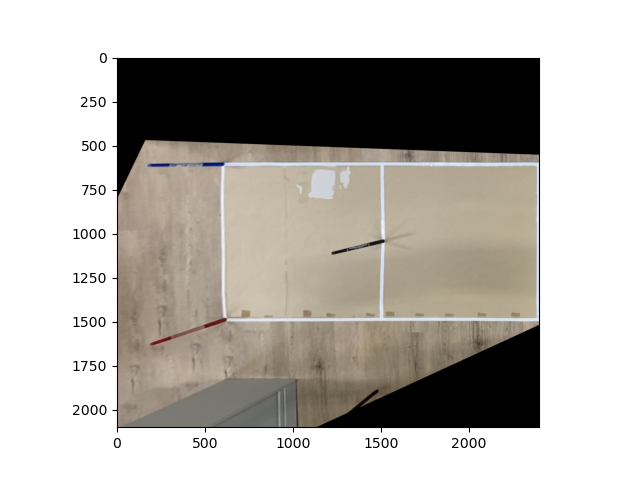

In [10]:
# cv2 : BGR
# matplotlib : RGB
plot_img = cv2.cvtColor(trans_img, cv2.COLOR_BGR2RGB)
plt.imshow(plot_img)

In [11]:
pb = [0, 0, 0]
pr = [0, 0, 0]
click = True

In [12]:
def click_pen(event, x, y, flags, params):
    global pb, pr, click
    if event == cv2.EVENT_LBUTTONDOWN:
        if click:
            pb = [x-margin, y-margin, 0]
        else:
            pr = [x-margin, y-margin, 0]
        click = not click
        print(x, y)

In [13]:
cv2.imshow("window4", trans_img)
cv2.setMouseCallback("window4", click_pen)
cv2.waitKey(0)
cv2.destroyAllWindows()

178 614
189 1634


In [14]:
real_b = [0, 0, 140]
real_r = [0, 900, 140]

blue_direction = [real - image for (real, image) in zip(real_b, pb)]
red_direction = [real - image for (real, image) in zip(real_r, pr)]

In [15]:
blue_direction

[422, -14, 140]

In [16]:
red_direction

[411, -134, 140]

In [17]:
points = 10

x_b = [pb[0]+i*blue_direction[0] for i in range(points)]
y_b = [pb[1]+i*blue_direction[1] for i in range(points)]
z_b = [pb[2]+i*blue_direction[2] for i in range(points)]

x_r = [pr[0]+i*red_direction[0] for i in range(points)]
y_r = [pr[1]+i*red_direction[1] for i in range(points)]
z_r = [pr[2]+i*red_direction[2] for i in range(points)]

<IPython.core.display.Javascript object>


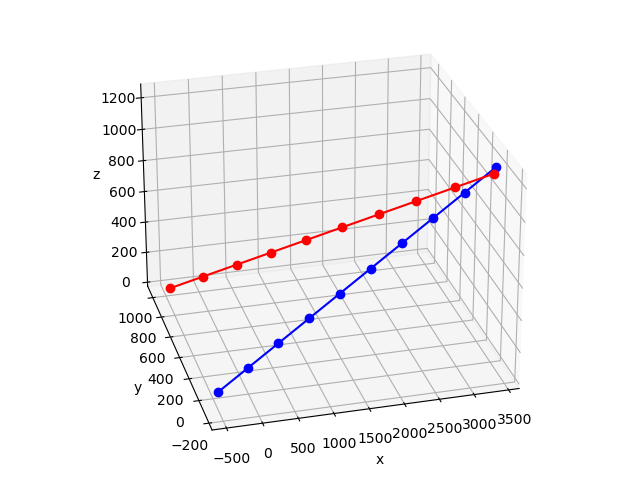

In [18]:
#3D Plot
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot(x_b, y_b, z_b, "o-", color="Blue")
ax.plot(x_r, y_r, z_r, "o-", color="Red")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### 3次元空間上のねじれた2直線の最近接点を求める
直線1：

    1点：pb
    
    ベクトル:blue_direction
    
    媒介変数：t
直線2：

    1点：pr

    ベクトル：red_direction
    
    媒介変数：s

In [20]:
#記号s, tを扱う
t = sympy.Symbol("t")
s = sympy.Symbol("s")

In [21]:
# 2乗距離
R = ((pb[0]+t*blue_direction[0]) - (pr[0]+s*red_direction[0]))**2+((pb[1]+t*blue_direction[1]) - (pr[1]+s*red_direction[1]))**2+((pb[2]+t*blue_direction[2]) - (pr[2]+s*red_direction[2]))**2

In [22]:
# 偏微分
dR_dt = sympy.diff(R, t)
dR_ds = sympy.diff(R, s)
print("dR/dt = ", dR_dt)
print("dR/ds = ", dR_ds)

dR/dt =  -389836*s + 395760*t + 19276
dR/ds =  412954*s - 389836*t - 264318


In [23]:
# 解く
ans = sympy.solve([dR_dt, dR_ds])
ans

{s: 6068250809/716160509, t: 5942535659/716160509}

In [24]:
t_val = ans[t]
s_val = ans[s]

In [25]:
b = [pb[0]+t_val*blue_direction[0], pb[1]+t_val*blue_direction[1], pb[2]+t_val*blue_direction[2]]
r = [pr[0]+s_val*red_direction[0], pr[1]+s_val*red_direction[1], pr[2]+s_val*red_direction[2]]

In [26]:
b

[2205530313300/716160509, -73169252100/716160509, 831954992260/716160509]

In [27]:
r

[2199709113300/716160509, -72635642100/716160509, 849555113260/716160509]

<IPython.core.display.Javascript object>


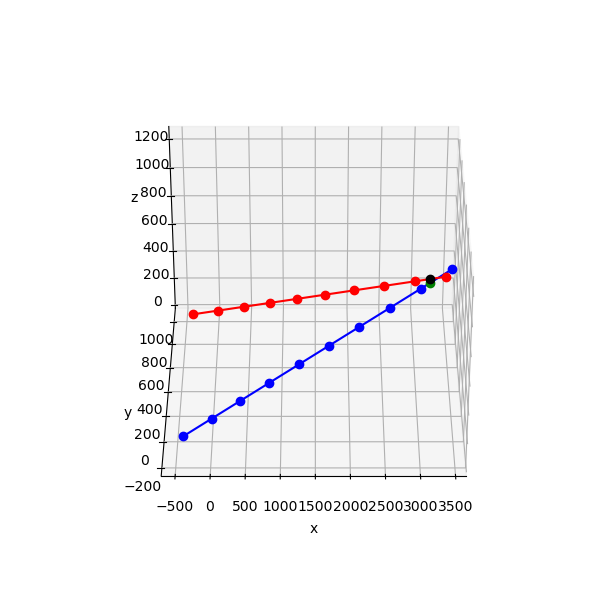

In [28]:
#3D Plot
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection="3d")
ax.plot(x_b, y_b, z_b, "o-", color="Blue")
ax.plot(x_r, y_r, z_r, "o-", color="Red")
ax.plot(b[0], b[1], b[2], "o-", color="Green")
ax.plot(r[0], r[1], r[2], "o-", color="Black")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [29]:
camera = [(b[0]+r[0])/2, (b[1]+r[1])/2, (b[2]+r[2])/2]
camera

[2202619713300/716160509, -72902447100/716160509, 840755052760/716160509]

In [30]:
black_coord = [0, 0, 0]

In [31]:
def print_coord(event, x, y, flags, params):
    global black_coord
    if event == cv2.EVENT_LBUTTONDOWN:
        black_coord = [x-margin, y-margin, 0]
        print(black_coord)

In [32]:
#黒ペンクリック
cv2.imshow("window2", trans_img)
cv2.setMouseCallback("window2", print_coord)
cv2.waitKey(0)
cv2.destroyAllWindows()

[626, 513, 0]


In [33]:
#方向ベクトル
black_direction = [camera[0]-black_coord[0], camera[1]-black_coord[1],camera[2]-black_coord[2]]

<IPython.core.display.Javascript object>


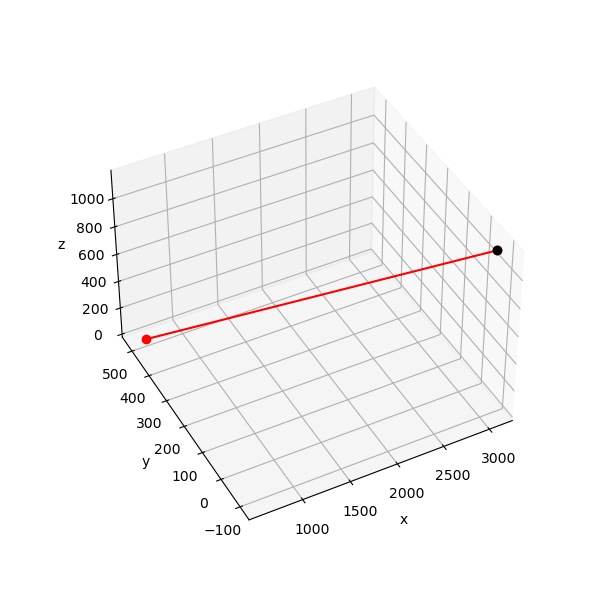

In [34]:
#3D Plot
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection="3d")
ax.plot([black_coord[0], camera[0]],[black_coord[1], camera[1]],[black_coord[2], camera[2]], "o-", color = "Red")
ax.plot(camera[0], camera[1], camera[2], "o-", color="Black")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [35]:
black_coord

[626, 513, 0]

## 統合

In [1]:
camera1 = [649953353700/205821701, 201663639450/205821701, 236578391140/205821701]
camera2 = [2202619713300/716160509, -72902447100/716160509, 840755052760/716160509]

black_coord1 = [604, 371, 0]
black_coord2 = [626, 513, 0]

NameError: name 'np' is not defined

In [38]:
direction1 = [camera1[0]-black_coord1[0], camera1[1]-black_coord1[1], camera1[2]-black_coord1[2]]
direction2 = [camera2[0]-black_coord2[0], camera2[1]-black_coord2[1], camera2[2]-black_coord2[2]]

In [39]:
# 極値問題を解く
t = sympy.Symbol("t")
s = sympy.Symbol("s")

R = ((camera1[0]+t*direction1[0]) - (camera2[0]+s*direction2[0]))**2 + ((camera1[1]+t*direction1[1]) - (camera2[1]+s*direction2[1]))**2 + ((camera1[2]+t*direction1[2]) - (camera2[2]+s*direction2[2]))**2

dR_dt = sympy.diff(R, t)
dR_ds = sympy.diff(R, s)

ans = sympy.solve([dR_dt, dR_ds])
ans

{s: -0.885713649455681, t: -0.882025338501382}

In [40]:
t_val = ans[t]
s_val = ans[s]

In [41]:
black1 = [camera1[0]+t_val*direction1[0], camera1[1]+t_val*direction1[1], camera1[2]+t_val*direction1[2]]
black2 = [camera2[0]+s_val*direction2[0], camera2[1]+s_val*direction2[1], camera2[2]+s_val*direction2[2]]

<IPython.core.display.Javascript object>


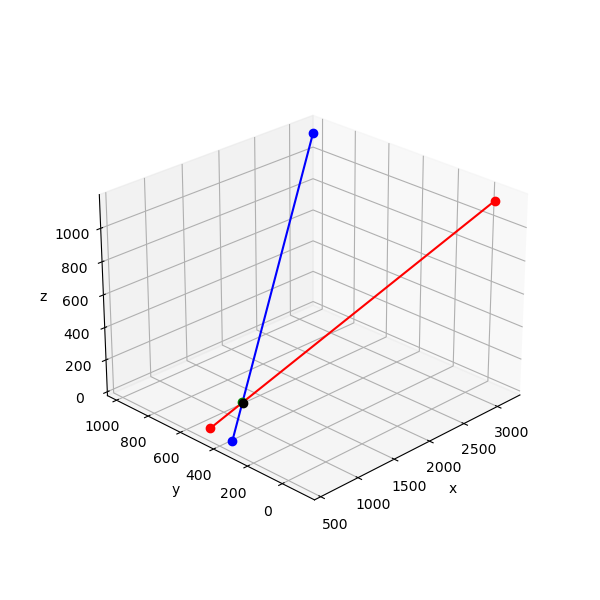

In [42]:
#3D Plot
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection="3d")
ax.plot([black_coord1[0], camera1[0]], [black_coord1[1], camera1[1]], [black_coord1[2], camera1[2]], "o-", color="Blue")
ax.plot([black_coord2[0], camera2[0]], [black_coord2[1], camera2[1]], [black_coord2[2], camera2[2]], "o-", color="Red")
ax.plot(black1[0], black1[1], black1[2], "o-", color="Green")
ax.plot(black2[0], black2[1], black2[2], "o-", color="Black")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [43]:
black = [(black1[0]+black2[0])/2, (black1[1]+black2[1])/2, (black1[2]+black2[2])/2]
black

[905.622231675388, 442.779944909853, 134.886724109919]

# 結果
XYZの誤差

X : +0.5cm

Y : -0.8cm

Z: -0.6cm